In [4]:
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import BRICS
def brics_decomp(mol):
    n_atoms = mol.GetNumAtoms()
    if n_atoms == 1:
        return [[0]], []

    cliques = []  #存储motif
    breaks = []
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        cliques.append([a1, a2])   #存储所有bond的list

    res = list(BRICS.FindBRICSBonds(mol))  #返回brics要断的键
    if len(res) == 0:
        return [list(range(n_atoms))], []
    else:
        for bond in res:
            if [bond[0][0], bond[0][1]] in cliques:
                cliques.remove([bond[0][0], bond[0][1]])
            else:
                cliques.remove([bond[0][1], bond[0][0]])
            cliques.append([bond[0][0]])
            cliques.append([bond[0][1]]) #brics要断的bond在cliques中拆成两个list

    # break bonds between rings and non-ring atoms
    for c in cliques:
        if len(c) > 1:
            if mol.GetAtomWithIdx(c[0]).IsInRing() and not mol.GetAtomWithIdx(c[1]).IsInRing():
                cliques.remove(c)
                cliques.append([c[1]])
                breaks.append(c)
            if mol.GetAtomWithIdx(c[1]).IsInRing() and not mol.GetAtomWithIdx(c[0]).IsInRing():
                cliques.remove(c)
                cliques.append([c[0]])    #拆掉一个atom在环上，另一个不在环上的bond，cliques只留下不在环的atom
                breaks.append(c)     #breaks加入该bond

    # select atoms at intersections as motif
    for atom in mol.GetAtoms():
        if len(atom.GetNeighbors()) > 2 and not atom.IsInRing():
            cliques.append([atom.GetIdx()])
            for nei in atom.GetNeighbors():
                if [nei.GetIdx(), atom.GetIdx()] in cliques:
                    cliques.remove([nei.GetIdx(), atom.GetIdx()])
                    breaks.append([nei.GetIdx(), atom.GetIdx()])
                elif [atom.GetIdx(), nei.GetIdx()] in cliques:
                    cliques.remove([atom.GetIdx(), nei.GetIdx()])
                    breaks.append([atom.GetIdx(), nei.GetIdx()])
                cliques.append([nei.GetIdx()])

    # merge cliques
    for c in range(len(cliques) - 1):
        if c >= len(cliques):
            break
        for k in range(c + 1, len(cliques)):
            if k >= len(cliques):
                break
            if len(set(cliques[c]) & set(cliques[k])) > 0:  #&交集
                cliques[c] = list(set(cliques[c]) | set(cliques[k])) #｜并集
                cliques[k] = []
        cliques = [c for c in cliques if len(c) > 0]
    cliques = [c for c in cliques if len(c) > 0]

    # edges
    edges = []  #断掉的edge
    for bond in res:
        for c in range(len(cliques)):
            if bond[0][0] in cliques[c]:
                c1 = c
            if bond[0][1] in cliques[c]:
                c2 = c
        edges.append((c1, c2))
    for bond in breaks:
        for c in range(len(cliques)):
            if bond[0] in cliques[c]:
                c1 = c
            if bond[1] in cliques[c]:
                c2 = c
        edges.append((c1, c2))

    return cliques, edges

In [20]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
    return mol

In [5]:
from MotifGraph import BricsDecompose

In [50]:
mol = Chem.MolFromSmiles("COC1=C(C=C(C=C1)Cl)C(=O)NCCC2=CC=C(C=C2)S(=O)(=O)NC(=O)NC3CCCCC3")
cliques = BricsDecompose.create_initial_cliques(mol)
# cliques = BricsDecompose.apply_brics_breaks(mol, cliques)
cliques, edges = brics_decomp(mol = mol)
edges

[(5, 6),
 (7, 8),
 (7, 9),
 (0, 1),
 (2, 6),
 (8, 10),
 (9, 4),
 (5, 1),
 (2, 3),
 (1, 11),
 (3, 10),
 (5, 12),
 (10, 13),
 (10, 14),
 (7, 15)]

{'[1*]C([6*])=O', '[12*]S(=O)(=O)c1ccc([16*])cc1', '[16*]c1ccc(Cl)cc1[16*]', '[4*]CC[8*]', '[5*]N[5*]', '[15*]C1CCCCC1', '[3*]OC', '[1*]C([1*])=O'}


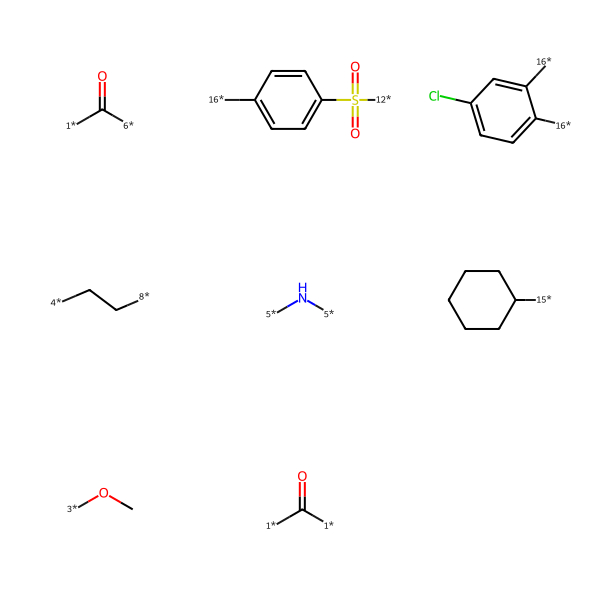

In [52]:
frags=BRICS.BRICSDecompose((mol))
print(frags)
mols = [Chem.MolFromSmiles(frag) for frag in frag]
img = Draw.MolsToGridImage(mols)
img

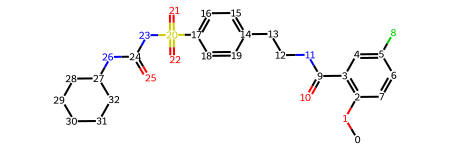

In [38]:
mol = Chem.MolFromSmiles("COC1=C(C=C(C=C1)Cl)C(=O)NCCC2=CC=C(C=C2)S(=O)(=O)NC(=O)NC3CCCCC3")
show_atom_number(mol, 'atomLabel')

In [55]:
res = list(BRICS.FindBRICSBonds(mol))
res[0]

((9, 11), ('1', '5'))

In [4]:
mol = Chem.MolFromSmiles("COC1=C(C=C(C=C1)Cl)C(=O)NCCC2=CC=C(C=C2)S(=O)(=O)NC(=O)NC3CCCCC3")
cliques, edges = brics_decomp(mol)
cliques

[[0, 1],
 [2, 3, 4, 5, 6, 7],
 [12, 13],
 [16, 17, 18, 19, 14, 15],
 [32, 27, 28, 29, 30, 31],
 [9],
 [11],
 [24],
 [23],
 [26],
 [20],
 [8],
 [10],
 [21],
 [22],
 [25]]

In [5]:
edges

[(1, 11), (3, 10)]

In [6]:
from rdkit import Chem
from collections import defaultdict
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

def tree_decomp(mol):
    # Get the number of atoms in the molecule
    n_atoms = mol.GetNumAtoms()
    # Base case: if the molecule has only one atom, return it as a single clique
    if n_atoms == 1:
        return [[0]], []

    cliques = []  # List to store atom indices in rings or bonds

    # Iterate over all bonds in the molecule
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()  # Index of the starting atom of the bond
        a2 = bond.GetEndAtom().GetIdx()    # Index of the ending atom of the bond
        # Add non-ring bonds as cliques
        if not bond.IsInRing():
            cliques.append([a1, a2])

    # Get rings in the molecule and add them to cliques
    ssr = [list(x) for x in Chem.GetSymmSSSR(mol)]
    cliques.extend(ssr)

    # Create a list of neighbors for each atom
    nei_list = [[] for _ in range(n_atoms)]
    for i, clique in enumerate(cliques):
        for atom in clique:
            nei_list[atom].append(i)

    # Merge rings with more than 2 atoms in common
    for i in range(len(cliques)):
        if len(cliques[i]) <= 2: continue
        for atom in cliques[i]:
            for j in nei_list[atom]:
                if i >= j or len(cliques[j]) <= 2: continue
                inter = set(cliques[i]) & set(cliques[j])
                if len(inter) > 2:
                    cliques[i].extend(cliques[j])
                    cliques[i] = list(set(cliques[i]))
                    cliques[j] = []

    # Remove empty cliques after merging
    cliques = [c for c in cliques if c]

    # Reinitialize and update the neighbor list
    nei_list = [[] for _ in range(n_atoms)]
    for i, clique in enumerate(cliques):
        for atom in clique:
            nei_list[atom].append(i)

    # Initialize edges between cliques
    edges = defaultdict(int)
    for atom in range(n_atoms):
        if len(nei_list[atom]) <= 1:
            continue
        cnei = nei_list[atom]
        bonds = [c for c in cnei if len(cliques[c]) == 2]
        rings = [c for c in cnei if len(cliques[c]) > 4]

        # Handling different configurations of bonds and rings
        if len(bonds) > 2 or (len(bonds) == 2 and len(cnei) > 2):
            # Add singleton cliques for complex configurations
            cliques.append([atom])
            c2 = len(cliques) - 1
            for c1 in cnei:
                edges[(c1, c2)] = 1
        elif len(rings) > 2:  # Multiple complex rings
            cliques.append([atom])
            c2 = len(cliques) - 1
            for c1 in cnei:
                edges[(c1, c2)] = MST_MAX_WEIGHT - 1
        else:
            # Create edges based on intersections between cliques
            for i in range(len(cnei)):
                for j in range(i + 1, len(cnei)):
                    c1, c2 = cnei[i], cnei[j]
                    inter = set(cliques[c1]) & set(cliques[c2])
                    if edges[(c1, c2)] < len(inter):
                        edges[(c1, c2)] = len(inter)

    # Prepare edge data for maximum spanning tree computation
    edges = [u + (MST_MAX_WEIGHT - v,) for u, v in edges.items()]
    if len(edges) == 0:
        return cliques, edges

    # Compute the maximum spanning tree of the clique graph
    row, col, data = zip(*edges)
    n_clique = len(cliques)
    clique_graph = csr_matrix((data, (row, col)), shape=(n_clique, n_clique))
    junc_tree = minimum_spanning_tree(clique_graph)
    row, col = junc_tree.nonzero()
    edges = [(row[i], col[i]) for i in range(len(row))]

    return cliques, edges
